In [1]:
## Imports
import json
import torch

from classes import  CI_LOADER, CIFAKE_CNN, get_files
from test import test_model, score_preds, test_thresh_size, visualise
from train import train_model

with open('./config.json') as f:
    config = json.load(f)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <EA7F9DF5-8854-31D8-89D4-BD566CAF4DEA> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <03BFC270-EF54-36FC-B102-371F5164D3C9> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load data

In [2]:
# load data
data = get_files(config['CIFAKE_dir'])
# Split data
trainfiles = data['train']
testfiles = data['test']

len(trainfiles), trainfiles[0]

(100000, ('../data/CIFAKE/train/REAL/1006 (3).jpg', 'REAL'))

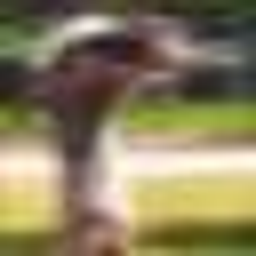

In [3]:
from PIL import Image
(Image.open(trainfiles[0][0])).resize((32*8,32*8))

In [4]:
traindata = CI_LOADER(trainfiles, batch_size=32)
testdata = CI_LOADER(testfiles, batch_size=32)

### Base model
Cifar10_tutorial.ipynb; mod for binary classification  
also very similar to structure decribed in Bird & Lotfi (2024)
'simple' CNN with FCN

CNN+Linear layers with maxpooling  
Conv2d(3, 6, 5),  
ReLU(),  
MaxPool2d(2, 2),  
Conv2d(6, 16, 5),  
ReLU(),  
MaxPool2d(2, 2),  
Flatten(),  
Linear(16 * 5 * 5, 120),
ReLU(),  
Linear(120, 84),  
ReLU(),  
Linear(84, 10)  
Sigmoid()  

In [5]:
# init and train base model
basemodel = CIFAKE_CNN()
# default lr=0.001, momentum=0.9
basemodel = train_model(basemodel, traindata, epochs=10, log=True)

  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 0	total loss: 2016.301196873188	avg loss: 0.6452163829994202


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 1	total loss: 1302.2143503725529	avg loss: 0.4167085921192169


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 2	total loss: 1077.599063307047	avg loss: 0.344831700258255


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 3	total loss: 919.5548523664474	avg loss: 0.2942575527572632


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 4	total loss: 828.0844607688487	avg loss: 0.2649870274460316


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 5	total loss: 774.0715830363333	avg loss: 0.24770290657162666


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 6	total loss: 733.5366868898273	avg loss: 0.2347317398047447


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 7	total loss: 704.5384851172566	avg loss: 0.22545231523752213


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 8	total loss: 682.3218051176518	avg loss: 0.2183429776376486


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 9	total loss: 660.9967078976333	avg loss: 0.21151894652724265
Finished Training


In [68]:
# save basemodel
# torch.save(basemodel.state_dict(), config['base_model'])

### Testing base model

In [7]:
basemodel = CIFAKE_CNN()
basemodel.load_state_dict(torch.load(config['base_model']))

<All keys matched successfully>

In [8]:
# predict labels
gold_b, preds_b = test_model(basemodel, testdata)
# evaluate with accuracy, precision, recall, f1-score
scores = score_preds(gold_b, preds_b, verbose=True, per_class=True)

  0%|          | 0/625 [00:00<?, ?it/s]


Performance (n=20000 test imgs, decision threshold=0.5)
Overall accuracy: 91.70%

               Fake      Real   Average
precision  0.896002  0.940239  0.918120
recall     0.943400  0.890500  0.916950
f1-score   0.919090  0.914694  0.916892


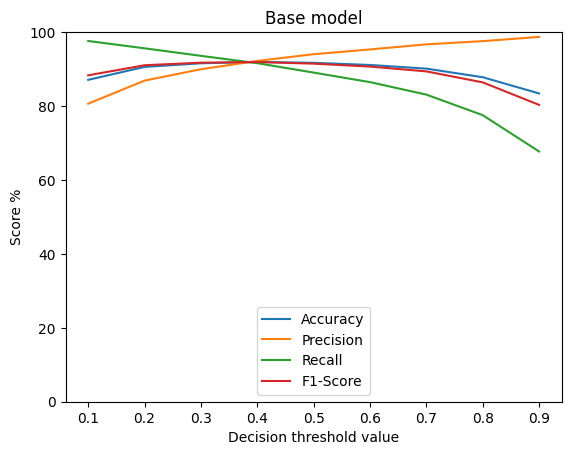

In [65]:
# explore effect of threshold size
base_thresh_df = test_thresh_size(gold_b, preds_b)
visualise(base_thresh_df, title='Base model')

In [10]:
# concrete values
base_thresh_df

,Accuracy,Precision,Recall,F1-Score
0.1,87.085,80.641163,97.60,88.313804
0.2,90.590,86.879884,95.62,91.040655
0.3,91.570,89.963469,93.58,91.736104
0.4,91.930,92.208577,91.60,91.903281
0.5,91.695,94.023862,89.05,91.469365
0.6,91.110,95.315256,86.47,90.677433
0.7,90.125,96.694984,83.09,89.377723
0.8,87.795,97.558827,77.53,86.398841
0.9,83.405,98.702435,67.70,80.313186


In [11]:
# meta data on threshold exploration
base_thresh_df.describe()

,Accuracy,Precision,Recall,F1-Score
count,9.000000,9.000000,9.000000,9.000000
mean,89.478333,92.443162,86.915556,89.025599
std,2.851813,5.816090,9.572088,3.738742
min,83.405000,80.641163,67.700000,80.313186
25%,87.795000,89.963469,83.090000,88.313804
50%,90.590000,94.023862,89.050000,90.677433
75%,91.570000,96.694984,93.580000,91.469365
max,91.930000,98.702435,97.600000,91.903281


In [12]:
# find peak for each metric
for x in zip([a for a in base_thresh_df.max().items()], base_thresh_df.idxmax()):
    print(x)

(('Accuracy', 91.93), 0.4)
(('Precision', 98.70243475725324), 0.9)
(('Recall', 97.6), 0.1)
(('F1-Score', 91.9032808267282), 0.4)


## SRM attention modified model

In [78]:
# run with attn post conv2ds
attn_model = CIFAKE_CNN(attn=True)
attn_model = train_model(attn_model, traindata, epochs=10, log=True)

  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 0	total loss: 2048.779287427664	avg loss: 0.6556093719768524


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 1	total loss: 1320.0119801163673	avg loss: 0.42240383363723755


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 2	total loss: 1008.5584765560925	avg loss: 0.3227387124979496


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 3	total loss: 889.2266224324703	avg loss: 0.28455251917839053


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 4	total loss: 825.9415668100119	avg loss: 0.2643013013792038


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 5	total loss: 778.209074255079	avg loss: 0.24902690376162528


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 6	total loss: 741.3493391387165	avg loss: 0.23723178852438925


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 7	total loss: 715.2151018492877	avg loss: 0.22886883259177207


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 8	total loss: 684.529729006812	avg loss: 0.21904951328217984


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 9	total loss: 667.711059352383	avg loss: 0.21366753899276256
Finished Training


In [79]:
gold_a, preds_a = test_model(attn_model, testdata)
scores = score_preds(gold_a, preds_a, verbose=True, per_class=True)

  0%|          | 0/625 [00:00<?, ?it/s]


Performance (n=20000 test imgs, decision threshold=0.5)
Overall accuracy: 92.06%

               Fake      Real   Average
precision  0.919768  0.921535  0.920652
recall     0.921700  0.919600  0.920650
f1-score   0.920733  0.920567  0.920650


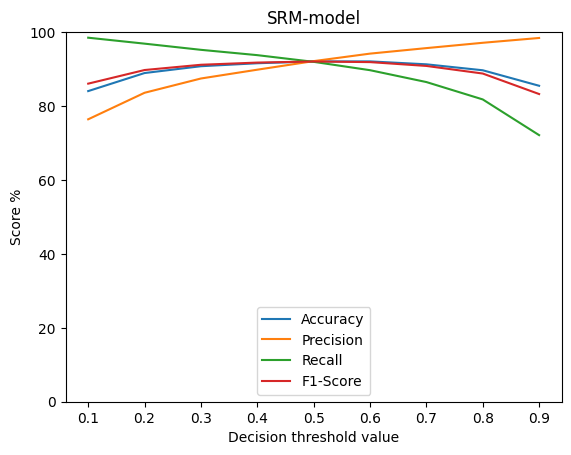

In [80]:
attn_df = test_thresh_size(gold_a, preds_a)
visualise(attn_df, title='SRM-model')

In [84]:
attn_df

,Accuracy,Precision,Recall,F1-Score
0.1,84.045,76.413996,98.49,86.058806
0.2,88.930,83.589301,96.88,89.745252
0.3,90.775,87.452926,95.21,91.166754
0.4,91.580,89.835217,93.77,91.760446
0.5,92.065,92.153522,91.96,92.056659
0.6,92.080,94.183116,89.70,91.886908
0.7,91.290,95.674779,86.49,90.850840
0.8,89.680,97.114700,81.79,88.796005
0.9,85.485,98.417247,72.13,83.247735


In [85]:
attn_df.describe()

,Accuracy,Precision,Recall,F1-Score
count,9.000000,9.000000,9.000000,9.000000
mean,89.547778,90.537200,89.602222,89.507712
std,2.928433,7.118657,8.384063,3.029731
min,84.045000,76.413996,72.130000,83.247735
25%,88.930000,87.452926,86.490000,88.796005
50%,90.775000,92.153522,91.960000,90.850840
75%,91.580000,95.674779,95.210000,91.760446
max,92.080000,98.417247,98.490000,92.056659


In [86]:
# find peak for each metric
for x in zip([a for a in attn_df.max().items()], attn_df.idxmax()):
    print(x)

(('Accuracy', 92.08), 0.6)
(('Precision', 98.41724655478237), 0.9)
(('Recall', 98.49), 0.1)
(('F1-Score', 92.05665949246709), 0.5)


In [87]:
torch.save(attn_model.state_dict(), config['attn_model'])

In [ ]:
# plot trainig acc vs val accuracy vs loss... (future work)

In [ ]:
# plot attention heat maps ...(future work)

### Experiments with more epochs

In [49]:
attn_model_large = CIFAKE_CNN(attn=True)
attn_model_large = train_model(attn_model_large, traindata, epochs=20, log=True)

  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 0	total loss: 2027.0759650468826	avg loss: 0.6486643088150025


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 1	total loss: 1267.701547242701	avg loss: 0.40566449511766434


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 2	total loss: 1005.4781275093555	avg loss: 0.3217530008029938


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 3	total loss: 934.538380574435	avg loss: 0.2990522817838192


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 4	total loss: 882.8911293484271	avg loss: 0.28252516139149664


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 5	total loss: 841.2776983380318	avg loss: 0.2692088634681702


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 6	total loss: 801.4382975772023	avg loss: 0.2564602552247047


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 7	total loss: 766.9741750396788	avg loss: 0.24543173601269722


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 8	total loss: 737.3496979139745	avg loss: 0.23595190333247185


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 9	total loss: 715.364981032908	avg loss: 0.22891679393053055


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 10	total loss: 698.7386183589697	avg loss: 0.2235963578748703


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 11	total loss: 679.2305990196764	avg loss: 0.21735379168629645


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 12	total loss: 666.3584949038923	avg loss: 0.21323471836924554


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 13	total loss: 652.3579946942627	avg loss: 0.20875455830216408


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 14	total loss: 634.3807449806482	avg loss: 0.20300183839380742


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 15	total loss: 624.2054665833712	avg loss: 0.19974574930667877


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 16	total loss: 610.9714258182794	avg loss: 0.19551085626184941


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 17	total loss: 594.7464099284261	avg loss: 0.19031885117709638


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 18	total loss: 585.3018162585795	avg loss: 0.18729658120274545


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 19	total loss: 578.1974831465632	avg loss: 0.18502319460690023
Finished Training


In [51]:
# predict labels
g, p = test_model(attn_model_large, testdata)
# evaluate with accuracy, precision, recall, f1-score
sc = score_preds(g, p, verbose=True, per_class=True)

  0%|          | 0/625 [00:00<?, ?it/s]


Performance (n=20000 test imgs, decision threshold=0.5)
Overall accuracy: 92.38%

               Fake      Real   Average
precision  0.908609  0.940272  0.924441
recall     0.942500  0.905200  0.923850
f1-score   0.925244  0.922403  0.923824


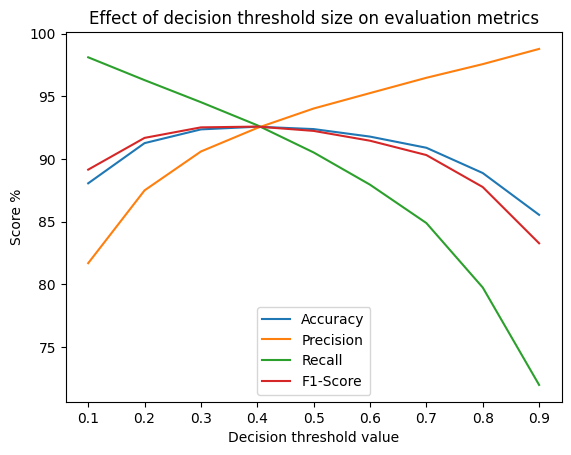

In [52]:
attn_l_df = test_thresh_size(g, p)
visualise(attn_l_df)

In [58]:
base_model_large = CIFAKE_CNN()
base_model_large = train_model(base_model_large, traindata, epochs=50, log=True)

  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 0	total loss: 1997.4799433350563	avg loss: 0.639193581867218


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 1	total loss: 1369.519143089652	avg loss: 0.43824612578868866


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 2	total loss: 1067.4718258306384	avg loss: 0.3415909842658043


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 3	total loss: 910.8240444622934	avg loss: 0.2914636942279339


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 4	total loss: 823.7699183374643	avg loss: 0.2636063738679886


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 5	total loss: 771.6805814653635	avg loss: 0.2469377860689163


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 6	total loss: 732.0400757845491	avg loss: 0.23425282425105573


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 7	total loss: 705.470319064334	avg loss: 0.2257505021005869


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 8	total loss: 682.4719821438193	avg loss: 0.2183910342860222


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 9	total loss: 655.3586929235607	avg loss: 0.20971478173553942


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 10	total loss: 634.4306121561676	avg loss: 0.20301779588997365


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 11	total loss: 620.9586463272572	avg loss: 0.1987067668247223


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 12	total loss: 602.3939082855359	avg loss: 0.19276605065137148


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 13	total loss: 591.23849345278	avg loss: 0.18919631790488958


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 14	total loss: 573.1870791558176	avg loss: 0.18341986532986165


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 15	total loss: 559.91727501899	avg loss: 0.1791735280060768


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 16	total loss: 548.43661785312	avg loss: 0.17549971771299838


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 17	total loss: 536.8069363459945	avg loss: 0.17177821963071824


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 18	total loss: 526.2123955888674	avg loss: 0.16838796658843755


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 19	total loss: 516.0006520785391	avg loss: 0.16512020866513252


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 20	total loss: 505.4552346877754	avg loss: 0.1617456751000881


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 21	total loss: 494.0047128153965	avg loss: 0.1580815081009269


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 22	total loss: 483.4013611525297	avg loss: 0.1546884355688095


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 23	total loss: 474.5840009720996	avg loss: 0.15186688031107187


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 24	total loss: 462.97978728311136	avg loss: 0.14815353193059563


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 25	total loss: 454.75472092535347	avg loss: 0.1455215106961131


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 26	total loss: 447.06162899918854	avg loss: 0.14305972127974034


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 27	total loss: 437.42444049101323	avg loss: 0.13997582095712424


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 28	total loss: 425.57702379557304	avg loss: 0.13618464761458338


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 29	total loss: 413.8111288398504	avg loss: 0.13241956122875215


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 30	total loss: 403.52218811167404	avg loss: 0.1291271001957357


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 31	total loss: 393.7806534441188	avg loss: 0.126009809102118


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 32	total loss: 380.8272248553112	avg loss: 0.12186471195369959


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 33	total loss: 370.2010349156335	avg loss: 0.11846433117300272


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 34	total loss: 360.7746632208582	avg loss: 0.11544789223067463


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 35	total loss: 347.1986743924208	avg loss: 0.11110357580557466


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 36	total loss: 343.4197492673993	avg loss: 0.10989431976556778


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 37	total loss: 328.7696221778169	avg loss: 0.10520627909690142


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 38	total loss: 316.3255717107095	avg loss: 0.10122418294742704


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 39	total loss: 305.31901537813246	avg loss: 0.0977020849210024


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 40	total loss: 293.4287716408726	avg loss: 0.09389720692507923


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 41	total loss: 281.4858546992764	avg loss: 0.09007547350376845


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 42	total loss: 273.6970969012473	avg loss: 0.08758307100839913


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 43	total loss: 265.62487408856396	avg loss: 0.08499995970834047


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 44	total loss: 256.5203462706413	avg loss: 0.08208651080660521


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 45	total loss: 244.19634624407627	avg loss: 0.0781428307981044


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 46	total loss: 234.67460176034365	avg loss: 0.07509587256330996


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 47	total loss: 222.9746987967519	avg loss: 0.0713519036149606


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 48	total loss: 210.3190720329294	avg loss: 0.06730210305053741


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 49	total loss: 208.39820369053632	avg loss: 0.06668742518097162
Finished Training


  0%|          | 0/625 [00:00<?, ?it/s]


Performance (n=20000 test imgs, decision threshold=0.5)
Overall accuracy: 91.98%

               Fake      Real   Average
precision  0.901501  0.939956  0.920729
recall     0.942700  0.897000  0.919850
f1-score   0.921641  0.917976  0.919808


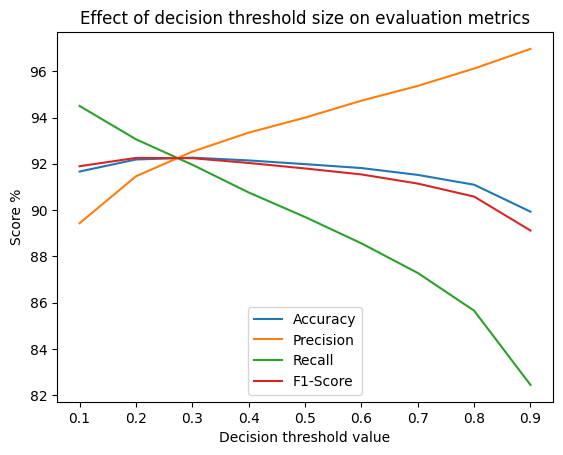

In [59]:
# predict labels
g2, p2 = test_model(base_model_large, testdata)
# evaluate with accuracy, precision, recall, f1-score
sc2 = score_preds(g2, p2, verbose=True, per_class=True)

base_l_df = test_thresh_size(g2, p2)
visualise(base_l_df)

## exp

In [88]:
exp = base_model_large
exp = train_model(exp, traindata, epochs=50, log=True)

  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 0	total loss: 195.04931306745857	avg loss: 0.06241578018158674


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 1	total loss: 193.02306373679312	avg loss: 0.0617673803957738


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 2	total loss: 187.38599929472548	avg loss: 0.059963519774312156


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 3	total loss: 174.8474458185956	avg loss: 0.05595118266195059


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 4	total loss: 168.84418624214595	avg loss: 0.054030139597486704


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 5	total loss: 153.56450098060304	avg loss: 0.04914064031379298


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 6	total loss: 156.3990636585513	avg loss: 0.05004770037073642


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 7	total loss: 142.89795959644835	avg loss: 0.04572734707086347


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 8	total loss: 145.08848896010022	avg loss: 0.04642831646723207


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 9	total loss: 126.39300718603772	avg loss: 0.04044576229953207


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 10	total loss: 131.25752560944238	avg loss: 0.04200240819502156


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 11	total loss: 127.84801504299685	avg loss: 0.04091136481375899


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 12	total loss: 122.05541138979606	avg loss: 0.03905773164473474


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 13	total loss: 117.14784561937267	avg loss: 0.03748731059819926


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 14	total loss: 110.68692049015954	avg loss: 0.03541981455685105


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 15	total loss: 97.1747926499811	avg loss: 0.031095933647993953


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 16	total loss: 111.8382795981961	avg loss: 0.03578824947142275


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 17	total loss: 103.99670922518271	avg loss: 0.03327894695205847


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 18	total loss: 98.9402129068003	avg loss: 0.031660868130176094


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 19	total loss: 84.2449783244665	avg loss: 0.02695839306382928


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 20	total loss: 101.46729931163281	avg loss: 0.0324695357797225


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 21	total loss: 85.73936755964678	avg loss: 0.02743659761908697


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 22	total loss: 85.38418866957727	avg loss: 0.027322940374264727


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 23	total loss: 82.15259750825135	avg loss: 0.02628883120264043


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 24	total loss: 80.4324943619531	avg loss: 0.025738398195824994


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 25	total loss: 77.62669090771215	avg loss: 0.024840541090467887


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 26	total loss: 77.704064893147	avg loss: 0.024865300765807043


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 27	total loss: 83.1156087894633	avg loss: 0.026596994812628255


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 28	total loss: 57.91161746567013	avg loss: 0.01853171758901444


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 29	total loss: 55.76380121171792	avg loss: 0.017844416387749733


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 30	total loss: 66.17439605436994	avg loss: 0.02117580673739838


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 31	total loss: 59.58920192383357	avg loss: 0.019068544615626744


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 32	total loss: 57.8667767750876	avg loss: 0.018517368568028034


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 33	total loss: 61.02121063228367	avg loss: 0.019526787402330773


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 34	total loss: 61.062286558689266	avg loss: 0.019539931698780565


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 35	total loss: 38.100742104703386	avg loss: 0.012192237473505084


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 36	total loss: 19.3573628684822	avg loss: 0.006194356117914303


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 37	total loss: 48.09435160961402	avg loss: 0.015390192515076487


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 38	total loss: 53.93998640158179	avg loss: 0.017260795648506175


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 39	total loss: 70.98740614036979	avg loss: 0.022715969964918332


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 40	total loss: 59.52599606095737	avg loss: 0.019048318739506357


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 41	total loss: 48.95265945612141	avg loss: 0.01566485102595885


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 42	total loss: 42.09287564021156	avg loss: 0.013469720204867698


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 43	total loss: 42.253574797145575	avg loss: 0.013521143935086584


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 44	total loss: 22.216208998061347	avg loss: 0.007109186879379631


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 45	total loss: 6.994074349829248	avg loss: 0.002238103791945359


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 46	total loss: 2.4323241369486936	avg loss: 0.0007783437238235819


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 47	total loss: 1.674232769347043	avg loss: 0.0005357544861910537


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 48	total loss: 1.40481313033996	avg loss: 0.0004495402017087872


  0%|          | 0/3125 [00:00<?, ?it/s]

epoch: 49	total loss: 1.2034435045448788	avg loss: 0.0003851019214543612
Finished Training


  0%|          | 0/625 [00:00<?, ?it/s]


Performance (n=20000 test imgs, decision threshold=0.5)
Overall accuracy: 91.72%

               Fake      Real   Average
precision  0.920488  0.914062  0.917275
recall     0.913400  0.921100  0.917250
f1-score   0.916930  0.917567  0.917249


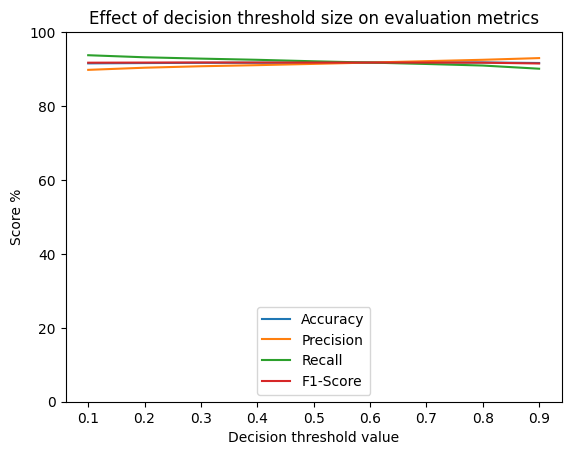

In [89]:
# predict labels
g3, p3 = test_model(exp, testdata)
# evaluate with accuracy, precision, recall, f1-score
sc3 = score_preds(g3, p3, verbose=True, per_class=True)

exp_df = test_thresh_size(g3, p3)
visualise(exp_df)

In [92]:
sc3 = score_preds(g3, p3, verbose=True, per_class=True, thresh=0.01)



Performance (n=20000 test imgs, decision threshold=0.01)
Overall accuracy: 90.61%

               Fake      Real   Average
precision  0.945572  0.872968  0.909270
recall     0.861700  0.950400  0.906050
f1-score   0.901690  0.910040  0.905865


In [93]:
sc3 = score_preds(g3, p3, verbose=True, per_class=True, thresh=0.99)



Performance (n=20000 test imgs, decision threshold=0.99)
Overall accuracy: 91.14%

               Fake      Real   Average
precision  0.881573  0.946403  0.913988
recall     0.950600  0.872300  0.911450
f1-score   0.914786  0.907842  0.911314
